In [25]:
import pandas as pd
import numpy as np
import torch
from torchvision.io import read_image
from scipy import spatial
from pyproj import CRS, Transformer
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from sklearn.cluster import DBSCAN

In [2]:
model = torch.load('./models/crosswalk_MRCNN1_crosswalk_entire.pth')
model.eval()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
df_all = pd.read_csv('./data/img_metadata/399697_135518_401430_136935.csv')
dims = 60
overlap = 6

In [5]:
class Crosswalk():
    def __init__(self, box, score, img_id, img_bbox, img_dims):
        self.score = score
        self.img_id = img_id
#         self.boxes = [[(box[0], box[1]), (box[0] + box[2], box[1] + box[3])] for box in boxes]
#         self.boxes_proj = [[point_to_coord(box[0], img_dims, bbox), point_to_coord(box[1], img_dims, bbox)] for box in self.boxes]
        self.box = [(box[0], box[1]), (box[2], box[3])]
        self.box_coords = [point_to_coord(self.box[0], img_dims, img_bbox), point_to_coord(self.box[1], img_dims, img_bbox)]
        self.loc_26985 = get_center_coord(self.box_coords)
        self.loc_latlng = project_to_latlng(self.loc_26985)
        
def get_center_coord(bbox):
    xmin, ymax = bbox[0]
    xmax, ymin = bbox[1]
    return ((xmin + xmax) / 2, (ymin + ymax) / 2)
            
#Map a point in an image from the predicted bounding box to an actual coordinate
def point_to_coord(pt, img_dims, bbox):
    x, y = pt
    H, W = img_dims
    xmin, ymin, xmax, ymax = bbox
    x_len = xmax - xmin
    y_len = ymax - ymin
    x_ratio = x_len / W
    y_ratio = y_len / H
    x = (x * x_ratio) + xmin
    y = ymax - (y * y_ratio)
    
    return (x, y)

def project_to_latlng(pt):
    crs_4326 = CRS('epsg:4326')
    crs_proj = CRS('epsg:26985')
    transformer = Transformer.from_crs(crs_proj, crs_4326)
    pt_proj = transformer.transform(pt[0], pt[1])
    
    return pt_proj
        
class CrosswalkImage():
    def __init__(self, idx, anns, row, img_dims):
        self.filename = row['filename']
        self.id = idx
        self.img_dims = (img_dims[1], img_dims[2])
        self.bbox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
        self.img_coords = (row['lat'], row['lng'])
        
        self.crosswalks = []
        for box, score in zip(anns['boxes'], anns['scores']):
            if score > 0.7:
                self.crosswalks.append(Crosswalk(box.cpu().numpy(), score.cpu().numpy(), idx, self.bbox, self.img_dims))

In [6]:
#Run object detection on collected images
base_path = './data/aerial_images/399697_135518_401430_136935/'

img_tensors = [read_image(base_path + filename).to(device=device, dtype=torch.float32) / 255 for filename in df_all['filename']]
with torch.no_grad():
    anns = [model([img_tensor])[0] for img_tensor in img_tensors]

In [7]:
df_all['crosswalk_detected'] = 0
df_all['crosswalk_obj_idx'] = ''
#Process each detected crosswalk, converting predicted bounding boxes to real coordinates
crosswalk_objs = []
for i, ann in enumerate(anns):
    if len(ann['labels']) > 0:
        df_all['crosswalk_detected'].iloc[i] = 1
        df_all['crosswalk_obj_idx'].iloc[i] = len(crosswalk_objs)
        crosswalk_objs.append(CrosswalkImage(i, ann, df_all.iloc[i], img_tensors[0].shape))

C:\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


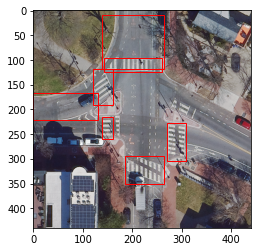

In [8]:
#Run object detection on collected images
base_path = './data/aerial_images/399697_135518_401430_136935/'
# filename = crosswalk_objs[intersection_idxs[0]].filename
filename = 'image_6.png'

img_tensor = read_image(base_path + filename).to(device=device, dtype=torch.float32) / 255
with torch.no_grad():
    ann = model([img_tensor])[0]

im = Image.open(base_path + filename)
fig, ax = plt.subplots()
ax.imshow(im)
for box in ann['boxes']:
    H = box[3] - box[1]
    W = box[2] - box[0]
    rect = patches.Rectangle((box[0], box[1]), W, H, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [10]:
def do_overlap(box1, box2):
    l1 = box1[0]
    r1 = box1[1]
    l2 = box2[0]
    r2 = box2[1]
    
    if l1[0] == r1[0] or l1[1] == r1[1] or r2[0] == l2[0] or l2[1] == r2[1]:
        return False
     
    # If one rectangle is on left side of other
    if l1[0] > r2[0] or l2[0] > r1[0]:
        return False
 
    # If one rectangle is above other
    if r1[1] > l2[1] or r2[1] > l1[1]:
        return False
 
    return True

def bbox_area(box):
    W = box[1][0] - box[0][0]
    H = box[0][1] - box[1][1]    
    return H * W

In [11]:
df_crosswalks = df_all[df_all['crosswalk_detected'] == 1]
# img_coords = list(zip((df_crosswalks['xmax'] + df_crosswalks['xmin']) / 2, (df_crosswalks['ymax'] + df_crosswalks['ymin']) / 2))
img_coords = list(zip(df_crosswalks['center_x'], df_crosswalks['center_y']))

In [12]:
kd_tree = spatial.KDTree(img_coords)
clusters_raw = kd_tree.query_ball_point(img_coords, dims)
clusters_set = {tuple(cluster) for cluster in clusters_raw}

In [13]:
intersection_idxs = kd_tree.query_ball_point([(400637.958184, 136191.700599), (401637.958184, 135191.700599)], 60)

In [16]:
all_crosswalks_overlap = []
for crosswalk_obj in crosswalk_objs:
    all_crosswalks_overlap.extend(crosswalk_obj.crosswalks)
len(all_crosswalks_overlap)

646

In [18]:
#Remove detected crosswalks that overlap across images
#If the bounding box of two crosswalks on the real world map overlap, keep the box with the larger area
for cluster in clusters_set:
    if len(cluster) <= 1:
        continue
    target = crosswalk_objs[cluster[0]]
    target_crosswalks = [crosswalk for crosswalk in target.crosswalks]
    for i in range(1, len(cluster)):
        comp = crosswalk_objs[cluster[i]]
        comp_crosswalks = [crosswalk for crosswalk in comp.crosswalks]
        for target_crosswalk in target_crosswalks:
            for comp_crosswalk in comp_crosswalks:
                if do_overlap(target_crosswalk.box_coords, comp_crosswalk.box_coords):
                    if bbox_area(target_crosswalk.box_coords) > bbox_area(comp_crosswalk.box_coords):
                        if comp_crosswalk in comp.crosswalks:
                            comp.crosswalks.remove(comp_crosswalk)
                    else:
                        if target_crosswalk in target.crosswalks:
                            target.crosswalks.remove(target_crosswalk)


In [19]:
#Accumulate all remaining crosswalk objects
all_crosswalks = []
for crosswalk_obj in crosswalk_objs:
    all_crosswalks.extend(crosswalk_obj.crosswalks)
len(all_crosswalks)

523

In [20]:
for i, crosswalk in enumerate(all_crosswalks):
    crosswalk.id = i

In [21]:
with open ('crosswalk_coords3.txt', 'w') as f:
    for coords in all_crosswalks:
        f.write(str(coords.loc_latlng[0]) + ',' + str(coords.loc_latlng[1]) + ',')
        f.write('\n')

In [22]:
#Cluster croswwalks into their respective 'families'
crosswalk_centers = np.asarray([crosswalk.loc_26985 for crosswalk in all_crosswalks])

In [53]:
clustering = DBSCAN(eps=30, min_samples=1).fit(crosswalk_centers)

In [36]:
all_crosswalks[-1].loc_26985

(38.89358421679597, -76.99833337481198)

In [54]:
class CrosswalkCluster():
    def __init__(self, id):
        self.id = id
        self.median_grade = 0
        self.mean_grade = 0
        self.observed_grades = []
        self.crosswalks = []

    def compute_center_coord(self):
        x_sum = 0
        y_sum = 0
        for crosswalk in self.crosswalks:
            x_sum += crosswalk.loc_26985[0]
            y_sum += crosswalk.loc_26985[1]
        self.center = (x_sum / len(self.crosswalks), y_sum / len(self.crosswalks))
        self.center_latlng = project_to_latlng(self.center)
            

In [55]:
crosswalk_clusters = []
for label in range(np.max(clustering.labels_)+1):
    crosswalk_clusters.append(CrosswalkCluster(label))

In [56]:
for i, cluster_label in enumerate(clustering.labels_):
    crosswalk_cluster = crosswalk_clusters[cluster_label]
    crosswalk_cluster.crosswalks.append(all_crosswalks[i])

for crosswalk_cluster in crosswalk_clusters:
    crosswalk_cluster.compute_center_coord()

In [57]:
with open ('cluster_coords.txt', 'w') as f:
    for crosswalk_cluster in crosswalk_clusters:
        f.write(str(crosswalk_cluster.center_latlng[0]) + ',' + str(crosswalk_cluster.center_latlng[1]) + ',red,square,"cluster",')
        f.write('\n')

In [58]:
cluster_coords = [cluster.center_latlng for cluster in crosswalk_clusters]
kd_tree_cluster = spatial.KDTree(cluster_coords)
res = kd_tree_cluster.query((38.892162418299506, -76.9883561760187), 3)
# clusters_set_ = {tuple(cluster) for cluster in clusters_raw}

In [59]:
res

(array([0.00015243, 0.00046508, 0.00055689]),
 array([ 81, 112,  15], dtype=int64))

In [64]:
crosswalk_clusters[81].center_latlng

(38.892015888321865, -76.98839815732575)